<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Convesations with Chat History Compression Enabled

AutoGen offers conversable agents powered by LLM, tool or human, which can be used to perform tasks collectively via automated chat. This framwork allows tool use and human participance through multi-agent conversation. Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

We now support compression of history messages.
In this notebook, we demonstrate how to use this feature through setting `compress_config` in `AssistantAgent`.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [ ]:
# %pip install pyautogen~=0.1.0

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [ ]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well).

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Compression example 1

In [2]:
import autogen
autogen.ChatCompletion.start_logging()
from autogen.agentchat.contrib.math_user_proxy_agent import MathUserProxyAgent

# 1. create an AssistantAgent instance named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant", 
    system_message="You are a helpful assistant.",
    llm_config={
        "request_timeout": 600,
        "seed": 43,
        "config_list": config_list,
    },
    compress_config={
        "trigger_count": 600, # set this to a large number for less frequent compression
    }
)

# 2. create the MathUserProxyAgent instance named "mathproxyagent"
# By default, the human_input_mode is "NEVER", which means the agent will not ask for human input.
mathproxyagent = MathUserProxyAgent(
    name="mathproxyagent", 
    human_input_mode="NEVER",
    code_execution_config={"use_docker": False},
    max_consecutive_auto_reply=5,
)
math_problem = "Find all $x$ that satisfy the inequality $(2x+10)(x+3)<(3x+9)(x+8)$. Express your answer in interval notation."
mathproxyagent.initiate_chat(assistant, problem=math_problem)

mathproxyagent (to assistant):

Let's use Python to solve a math problem.

Query requirements:
You should always use the 'print' function for the output and use fractions/radical forms instead of decimals.
You can use packages like sympy to help you.
You must follow the formats below to write your code:
```python
# your code
```

First state the key idea to solve the problem. You may choose from three ways to solve the problem:
Case 1: If the problem can be solved with Python code directly, please write a program to solve it. You can enumerate all possible arrangements if needed.
Case 2: If the problem is mostly reasoning, you can solve it by yourself directly.
Case 3: If the problem cannot be handled in the above two ways, please follow this process:
1. Solve the problem step by step (do not over-divide the steps).
2. Take out any queries that can be asked through Python (for example, any calculations or equations that can be calculated).
3. Wait for me to give the results.
4. Continu

## Compression example 2: function calls

user_proxy (to chatbot):

Draw two agents chatting with each other with an example dialog. Don't add plt.show().

--------------------------------------------------------------------------------
chatbot (to user_proxy):

***** Suggested function Call: python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\n
plt.figure(figsize=(10, 5))\n

# Representing two agents\n
plt.text(0.2, 0.4, 'Agent 1', ha='center', va='center', size=20, bbox=dict(boxstyle=\"rarrow\", fc=\"w\"))\n
plt.text(0.8, 0.6, 'Agent 2', ha='center', va='center', size=20, bbox=dict(boxstyle=\"larrow\", fc=\"w\"))\n

# Dialog lines\n
plt.plot([0.3, 0.7], [0.4, 0.6], 'k-')\n

# Dialog\n
plt.text(0.5, 0.5, '\"Hello!\"', ha='center', va='center', rotation=20)\n
plt.text(0.5, 0.5, '\"Hi!\"', ha='center', va='center', rotation=-15)\n

# Hide axes\n
plt.axis('off')"
}
*******************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FU

(0.27999999999999997, 0.72, 0.39, 0.61)

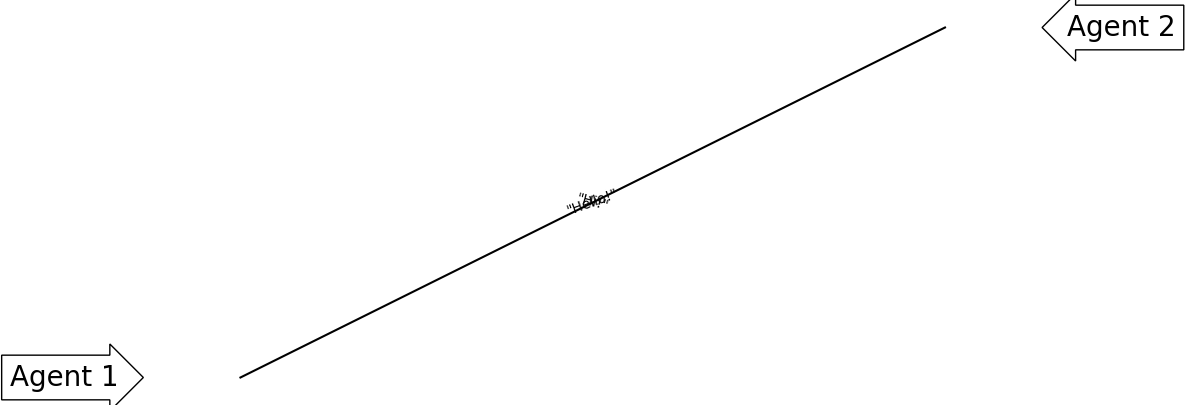

user_proxy (to chatbot):

***** Response from calling function "python" *****
(0.27999999999999997, 0.72, 0.39, 0.61)
***************************************************

--------------------------------------------------------------------------------
******************************Content after compressing:******************************
Compressed Content of Previous Chat:
ASSISTANT: None
FUNCTION_CALL: Called the "python" function with a cell that runs code to create a matplotlib plot with two agents, dialogue lines, and dialogues between the agents, and then hides the axes.
FUNCTION_RETURN: The coordinates (0.28, 0.72, 0.39, 0.61) are provided as the return value from the python function. 
********************************************************************************
Token Count(after the first user message): Before compression: 312 After: 96 | Total prompt token count after compression: 229
--------------------------------------------------------------------------------
chatbot (t

In [3]:
llm_config = {
    "functions": [
        {
            "name": "python",
            "description": "run cell in ipython and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "cell": {
                        "type": "string",
                        "description": "Valid Python cell to execute.",
                    }
                },
                "required": ["cell"],
            },
        },
        {
            "name": "sh",
            "description": "run a shell script and return the execution result.",
            "parameters": {
                "type": "object",
                "properties": {
                    "script": {
                        "type": "string",
                        "description": "Valid shell script to execute.",
                    }
                },
                "required": ["script"],
            },
        },
    ],
    "config_list": config_list,
    "request_timeout": 120,
}
chatbot = autogen.AssistantAgent(
    name="chatbot",
    system_message="For coding tasks, only use the functions you have been provided with. Reply TERMINATE when the task is done.",
    llm_config=llm_config,
    compress_config={
        "trigger_count": 300, # set this to a large number for less frequent compression
    }

)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    code_execution_config={"work_dir": "coding"},
)

# define functions according to the function desription
from IPython import get_ipython

def exec_python(cell):
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log

def exec_sh(script):
    return user_proxy.execute_code_blocks([("sh", script)])

# register the functions
user_proxy.register_function(
    function_map={
        "python": exec_python,
        "sh": exec_sh,
    }
)

# start the conversation
user_proxy.initiate_chat(
    chatbot,
    message="Draw two agents chatting with each other with an example dialog. Don't add plt.show().",
)
